# Transforming excel to df

In [1]:
import os 
from glob import glob
import pandas as pd
import numpy as np

In [19]:
#!pip install xlrd

     |████████████████████████████████| 103 kB 427 kB/s eta 0:00:01


In [2]:
import xlrd

### 1. Using `xlrd`

In [3]:
path = '../../Donnees_indices_fragilites_numeriques/'


#### Find path of xls into TauxdePauvrete folder


In [4]:
list_files= glob(os.path.join(path,'**/**/2019/*.xls'))
list_files[0]

'../../Donnees_indices_fragilites_numeriques/1 - Accès aux interfaces numériques/1 - Taux de pauvreté/2019/2A - Corse du Sud.xls'

# 1. Method to create dataframe

In [289]:
def create_dataframe(filename,columns = ['Dep','Commune','Libelle','revenu_fiscal_ref','num_foyers_fiscal'],start_row=23,start_col=1,end_col = 6):
    # load the first sheet
    wb = xlrd.open_workbook(filename=filename)
    sheet = wb.sheet_by_index(0)   
    data = [sheet.row_values(i,start_colx=start_col,end_colx=end_col) for i in range(start_row,sheet.nrows)]  # get the info
    df = pd.DataFrame(data,columns=columns)
    df['Dep'] = df['Dep'].transform(lambda x: x[:2]) #convert 060 to 06 (departement)
    return df

In [290]:
# Example 
df = create_dataframe(list_files[7])
df.head()

,Dep,Commune,Libelle,revenu_fiscal_ref,num_foyers_fiscal
0,06,001,Aiglun,Total,49
1,06,002,Amirat,Total,21
2,06,003,Andon,Total,348
3,06,004,Antibes,0 à 10 000,10235
4,06,004,Antibes,10 001 à 12 000,2526


In [24]:
df.isna().sum()

Dep                  0
Commune              0
Libelle              0
revenu_fiscal_ref    0
num_foyers_fiscal    0
dtype: int64

### pivot table revenu


In [7]:
for i,c in enumerate(list_files):
    if 'Corse' in c:
        print(i)

0
30


# 2. Method to get taux by deparment

####### changes a faire
1. NAN --- 0
2. Taux dans pourcentage
3. CODE (00)(000)

In [8]:
def get_info(file):
    # Method to get info
    df = create_dataframe(file)
    # pivot table to change revenu to columns
    table = pd.pivot_table(df, values='num_foyers_fiscal', index=['Dep','Commune','Libelle'],
                           columns=['revenu_fiscal_ref'], aggfunc=np.sum,fill_value=0).reset_index()
    # ----- calculating indices
    nx_10k = table['0 à 10 000']=='n.c.'
    nx_12k = table['10 001 à 12 000']=='n.c.'
    nx_total = table['Total'] =='n.c.'
    if table.loc[nx_10k,'Libelle'].count(): print('****N.C. in 10K\n',table.loc[nx_10k,['Dep','Libelle']])
    if table.loc[nx_12k,'Libelle'].count(): print('****N.C. in 12K\n',table.loc[nx_12k,['Dep','Libelle']])
    if table.loc[nx_total,'Libelle'].count(): print('****N.C. in Total\n',table.loc[nx_total,['Dep','Libelle']])


# information

> Notes from original file:
    - données disponibles uniquement pour 468/4454 communes
    - pour les 3986 communes restantes, le taux de pauvreté du département respectif a été pris en compte

In [9]:
#dataframe_total = pd.DataFrame(columns=['Libelle','num_foyers','Total','TX_POVERTY'])
for file in list_files[:5]:
    print("[[[{}]]] ".format(file.split('-')[-1]))
    df = get_info(file)
    #dataframe_total = pd.concat([dataframe_total,df])

[[[ Corse du Sud.xls]]] 
[[[ Drome.xls]]] 
****N.C. in 12K
 revenu_fiscal_ref Dep                   Libelle
312                26  Saint-Sorlin-en-Valloire
****N.C. in Total
 revenu_fiscal_ref Dep             Libelle
15                 26             Aucelon
16                 26               Aulan
27                 26  La Bâtie-des-Fonds
142                26     Izon-la-Bruisse
228                26   Le Poët-en-Percip
231                26            Pommerol
258                26       Rochefourchat
333                26          Les Tonils
[[[ Mayotte.xls]]] 
****N.C. in 12K
 revenu_fiscal_ref Dep        Libelle
0                  97          Acoua
1                  97     Bandraboua
3                  97         Bouéni
4                  97        Chiconi
8                  97      Kani-Kéli
11                 97      Mtsamboro
12                 97  M'Tsangamouji
13                 97       Ouangani
[[[ Taux de pauvreté/2019/430.xls]]] 
****N.C. in 12K
 revenu_fiscal_ref Dep 

In [78]:
def get_data(file):
    # 1. create dataframe from excel : ['Dep','Commune','Libelle','revenu_fiscal_ref','num_foyers_fiscal']
    # 2. NaN fill with 0 !
    df = create_dataframe(file)
    # pivot table to change revenu to columns
    table = pd.pivot_table(df, values='num_foyers_fiscal', index=['Dep','Commune','Libelle'],
                           columns=['revenu_fiscal_ref'], aggfunc=np.sum).reset_index()
    # ----- calculating indices
    # n.c. to Nan  num_foyers < 12 000
    table.loc[table['0 à 10 000'] == 'n.c.','0 à 10 000'] = np.nan
    table.loc[table['10 001 à 12 000']  == 'n.c.', '10 001 à 12 000'] = np.nan
    table.loc[table['Total']  == 'n.c.','Total'] = np.nan
    
    # TX_POVERTY = (number_foyers10k + number_foyers12k) / total
    taux = []
    for foyers_10k,foyers_12k,total in zip(table['0 à 10 000'],table['10 001 à 12 000'],table['Total']):
        if foyers_10k != np.nan and foyers_12k != np.nan:
            taux.append(((foyers_10k + foyers_12k) / total) * 100)
        elif foyers_10k == np.nan:
            taux.append(((foyers_12k) / total) * 100)
        else:
            taux.append(((foyers_10k) / total) * 100)
            
    table['TX_POVERTY'] = taux
    table['code_INSEE'] = table['Dep'] + table['Commune']
    return table[['code_INSEE','TX_POVERTY']]
    

# Testing 

# Where are the NaNs ?

In [291]:
dep06= get_data(list_files[7])
print(dep06.isna().sum())

revenu_fiscal_ref
code_INSEE      0
TX_POVERTY    103
dtype: int64


In [292]:
dep06.head()

revenu_fiscal_ref,code_INSEE,TX_POVERTY
0,06001,NaN
1,06002,NaN
2,06003,NaN
3,06004,24.384232
4,06005,NaN


In [293]:
## testing with data_gps.
data_gps = pd.read_csv('../data/data_gps.csv')
data_gps['code_INSEE'] = ['0'+str(X) if len(str(X)) < 5 else X for X in data_gps['code_INSEE']]
data_gps.columns = ['code_INSEE','latitude','longitude']

In [294]:
data_gps.head()

,code_INSEE,latitude,longitude
0,38075,45.461591,5.958008
1,38081,45.538065,5.116091
2,38085,45.739851,5.151117
3,38089,45.501096,5.512872
4,38092,45.054233,5.389574


In [295]:
data = pd.merge(dep06,data_gps,on='code_INSEE')
data.head()

,code_INSEE,TX_POVERTY,latitude,longitude
0,06001,NaN,43.852419,6.934942
1,06002,NaN,43.896297,6.812560
2,06003,NaN,43.776986,6.823186
3,06003,NaN,43.776986,6.823186
4,06004,24.384232,43.587465,7.106354


In [296]:
BBox = ((data.longitude.min(), data.longitude.max(),      
         data.latitude.min(), data.latitude.max()))
BBox

(6.690432969600001, 7.65147828925, 43.4985345439, 44.2894656829)

In [58]:
import matplotlib.pyplot as plt

In [ ]:
#conda install basemap

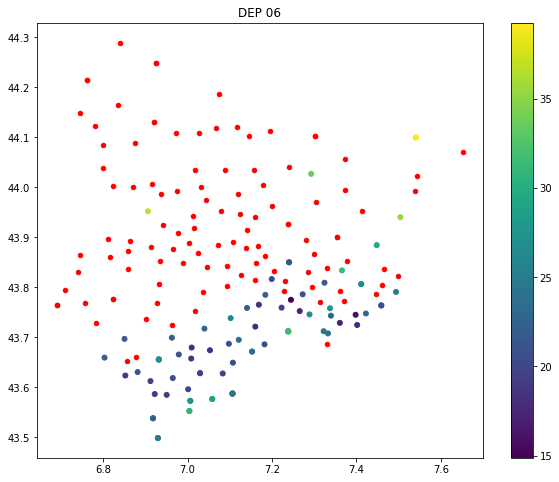

In [297]:
data = pd.merge(dep06,data_gps,on='code_INSEE')
data.head()
fig, ax = plt.subplots(figsize = (10,8))
index = data.TX_POVERTY.isna()
ax.scatter(data.longitude[index], data.latitude[index], c='r', s=20)
sc = ax.scatter(data.longitude[-index], data.latitude[-index], c=data.TX_POVERTY[-index], s=25)
plt.title('DEP 06')
fig.colorbar(sc)
plt.show()

In [237]:
data.describe()

,TX_POVERTY,latitude,longitude
count,82.000000,192.000000,192.000000
mean,24.237597,43.834398,7.106258
std,5.340479,0.171841,0.210946
min,14.879468,43.498535,6.690433
25%,20.526201,43.711999,6.931905
50%,22.968498,43.811115,7.099840
75%,26.853257,43.948743,7.249955
max,39.257504,44.289466,7.651478


In [192]:
for i,c in enumerate(list_files):
    if '29' in c:
        print(i)

70


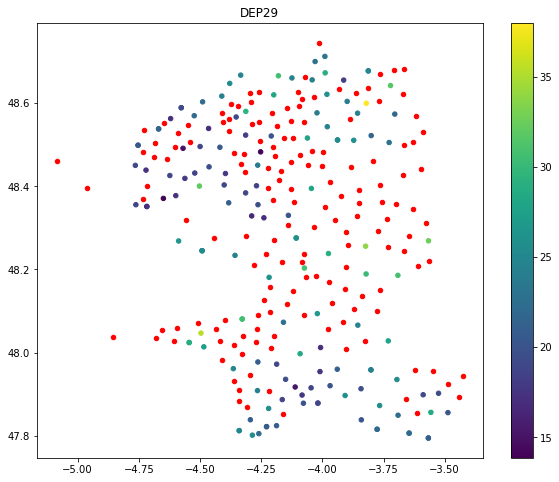

In [232]:
data = pd.merge(get_data(list_files[70]),data_gps,on='code_INSEE')

fig, ax = plt.subplots(figsize = (10,8))
index = data.TX_POVERTY.isna()
ax.scatter(data.longitude[index], data.latitude[index], c='r', s=20)
sc = ax.scatter(data.longitude[-index], data.latitude[-index], c=data.TX_POVERTY[-index], s=20)
plt.title('DEP29')
fig.colorbar(sc)
plt.show()

In [233]:
data.describe()

,TX_POVERTY,latitude,longitude
count,136.000000,295.000000,295.000000
mean,22.964588,48.286329,-4.136713
std,4.591941,0.266878,0.330245
min,13.868036,47.794341,-5.085345
25%,19.281160,48.040830,-4.354847
50%,22.217462,48.349531,-4.145808
75%,25.519968,48.513327,-3.885005
max,37.978690,48.745379,-3.426525


In [196]:
data_gps.loc[data_gps['code_INSEE'] == '75010']

,code_INSEE,latitude,longitude


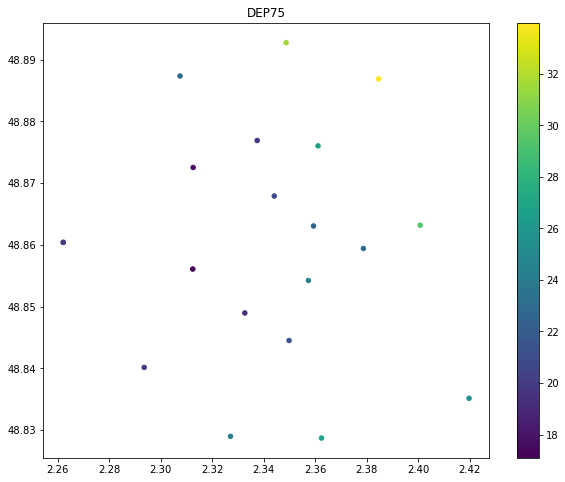

In [234]:
data = pd.merge(get_data(list_files[33]),data_gps,on='code_INSEE')

fig, ax = plt.subplots(figsize = (10,8))
sc = ax.scatter(data.longitude, data.latitude, c=data.TX_POVERTY, s=20)
plt.title('DEP75')
fig.colorbar(sc)
plt.show()

In [217]:
for i,c in enumerate(list_files):
    if '70' in c:
        print(i)

15
28
34
78
88


../../Donnees_indices_fragilites_numeriques/1 - Accès aux interfaces numériques/1 - Taux de pauvreté/2019/700.xls


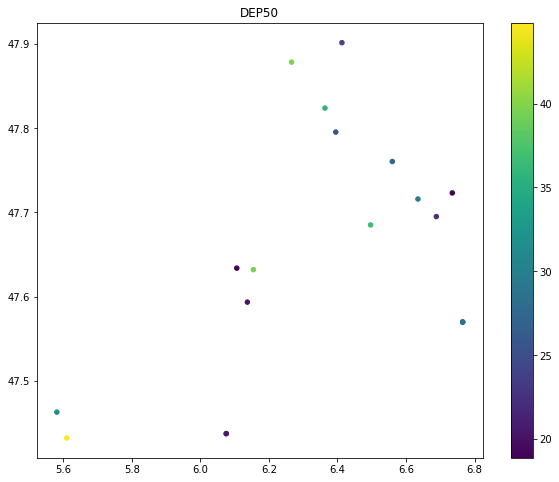

In [219]:
ind = 28
print(list_files[ind])
data = pd.merge(get_data(list_files[ind]),data_gps,on='code_INSEE')

fig, ax = plt.subplots(figsize = (10,8))
sc = ax.scatter(data.longitude, data.latitude, c=data.TX_POVERTY, s=20)
plt.title('DEP50')
fig.colorbar(sc)
plt.show()

# Create big csv 

In [339]:
dataframe_total = pd.DataFrame(columns=['code_INSEE','TX_POVERTY'])
for file in list_files:
    print("[[[{}]]] ".format(file.split('-')[-1]))
    # create dataset by departement and concatenate
    df = get_data(file)
    dataframe_total = pd.concat([dataframe_total,df])


[[[ Corse du Sud.xls]]] 
[[[ Drome.xls]]] 
[[[ Mayotte.xls]]] 
[[[ Taux de pauvreté/2019/430.xls]]] 
[[[ Taux de pauvreté/2019/740.xls]]] 
[[[ Taux de pauvreté/2019/940.xls]]] 
[[[ Taux de pauvreté/2019/650.xls]]] 
[[[ Alpes Maritime.xls]]] 
[[[ Taux de pauvreté/2019/730.xls]]] 
[[[ Isère.xls]]] 
[[[ Taux de pauvreté/2019/920.xls]]] 
[[[ Martinique.xls]]] 
[[[ Garonne.xls]]] 
[[[ Taux de pauvreté/2019/500.xls]]] 
[[[ Côte d'or.xls]]] 
[[[ Taux de pauvreté/2019/470.xls]]] 
[[[ Ardennes.xls]]] 
[[[ Landes.xls]]] 
[[[ Taux de pauvreté/2019/950.xls]]] 
[[[ Allier.xls]]] 
[[[ Taux de pauvreté/2019/530.xls]]] 
[[[ Ariège.xls]]] 
[[[ Taux de pauvreté/2019/580.xls]]] 
[[[ Marne.xls]]] 
[[[ Taux de pauvreté/2019/630.xls]]] 
[[[Maritime.xls]]] 
[[[ Gers.xls]]] 
[[[ Taux de pauvreté/2019/830.xls]]] 
[[[ Taux de pauvreté/2019/700.xls]]] 
[[[ Ardèche.xls]]] 
[[[Corse.xls]]] 
[[[ Charente.xls]]] 
[[[ Taux de pauvreté/2019/930.xls]]] 
[[[ Taux de pauvreté/2019/750.xls]]] 
[[[ Taux de pauvreté/2019/77

In [299]:
dataframe_total.head()

revenu_fiscal_ref,code_INSEE,TX_POVERTY
0,2A001,17.815483
1,2A004,27.441333
2,2A006,17.826087
3,2A008,NaN
4,2A011,NaN


In [340]:
dataframe_total.isna().sum()

revenu_fiscal_ref
code_INSEE        0
TX_POVERTY    29642
dtype: int64

In [301]:
dataframe_total.describe()

revenu_fiscal_ref,TX_POVERTY
count,5625.000000
mean,24.819514
std,8.790355
min,9.387755
25%,18.249354
50%,23.175599
75%,30.127922
max,72.405498


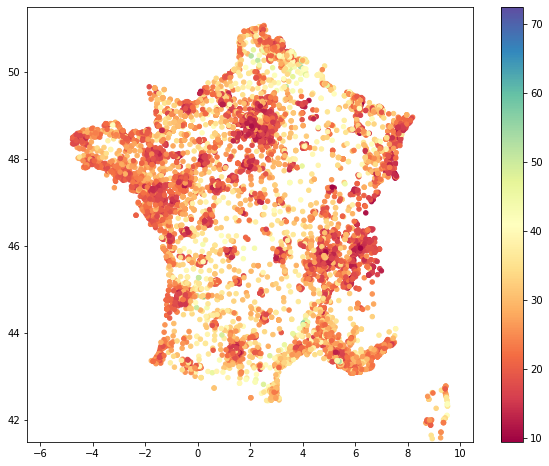

In [351]:
fig, ax = plt.subplots(figsize = (10,8))
index = data.TX_POVERTY.isna()
#ax.scatter(data.longitude[index], data.latitude[index], c='r', s=20)
sc = ax.scatter(data.longitude[-index], data.latitude[-index], c=data.TX_POVERTY[-index], s=20,cmap='Spectral')

ax.set_xlim(-6.5, 10.5)
ax.set_ylim(41.5, 51.5)
fig.colorbar(sc)
plt.show()

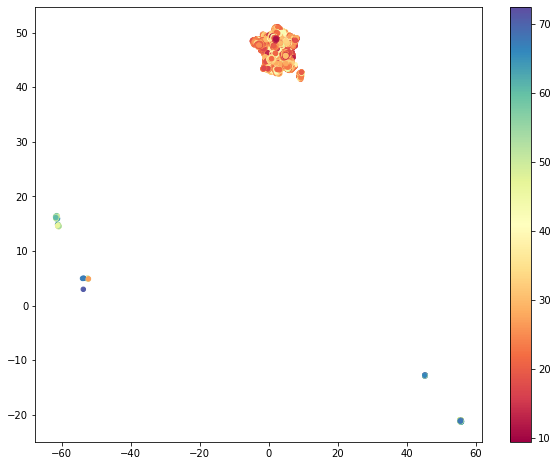

In [352]:
fig, ax = plt.subplots(figsize = (10,8))
index = data.TX_POVERTY.isna()
#ax.scatter(data.longitude[index], data.latitude[index], c='r', s=20)
sc = ax.scatter(data.longitude[-index], data.latitude[-index], c=data.TX_POVERTY[-index], s=20,cmap='Spectral')
fig.colorbar(sc)
plt.show()

In [17]:
dataframe_total.to_csv('../data/taux_pauvrete.csv',index=False)

Two approaches to complete the data.
1. mean
2. clustering

In [259]:
from sklearn.cluster import SpectralClustering
import numpy as np

In [281]:
x = data[-index]
x = x.drop(columns='code_INSEE')
x.dropna(inplace=True)

In [286]:
x.head()

,TX_POVERTY,latitude,longitude
1,27.441333,41.934793,8.701323
2,27.441333,41.934793,8.701323
3,27.441333,41.934793,8.701323
4,17.826087,41.973519,8.731332
9,21.087160,42.003202,8.733556


In [331]:
data_test

,code_INSEE,TX_POVERTY,latitude,longitude
0,06001,21.977547,43.852419,6.934942
1,06002,21.977547,43.896297,6.812560
2,06003,21.977547,43.776986,6.823186
3,06003,21.977547,43.776986,6.823186
4,06004,24.384232,43.587465,7.106354
...,...,...,...,...
188,06160,21.977547,44.122142,6.781905
189,06161,20.511134,43.649256,7.107284
190,06162,21.977547,44.071456,7.651478
191,06163,39.257504,44.099767,7.540532


In [446]:
list_files[15]

'../../Donnees_indices_fragilites_numeriques/1 - Accès aux interfaces numériques/1 - Taux de pauvreté/2019/470.xls'

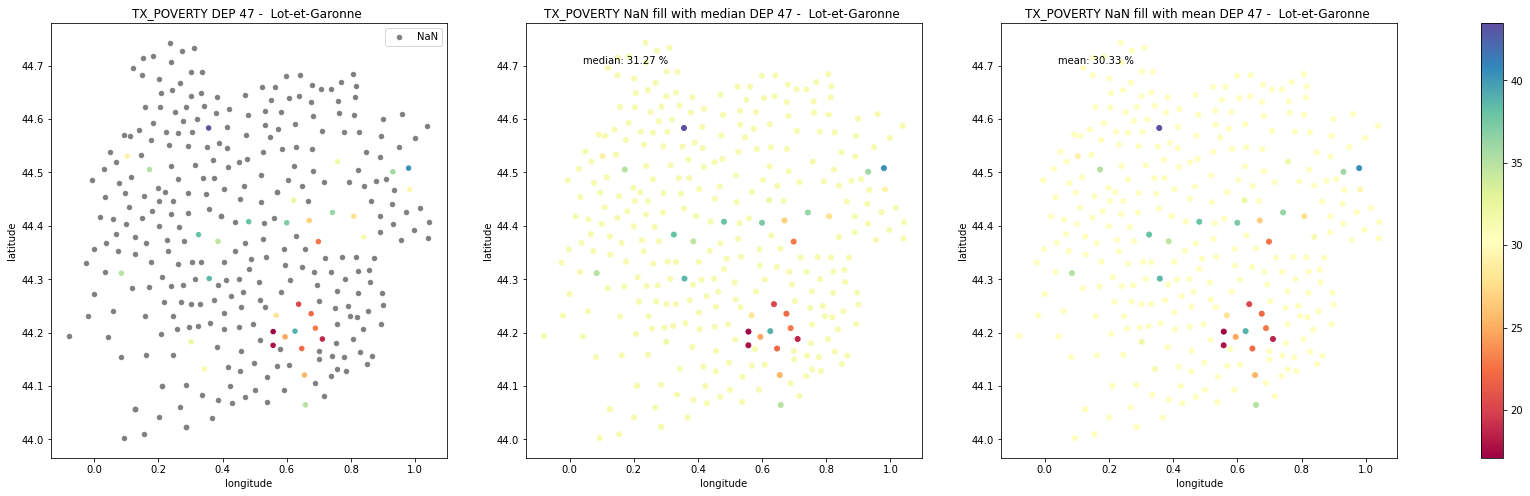

In [448]:
data = pd.merge(get_data(list_files[15]),data_gps,on='code_INSEE')
data_fill_median = data.fillna(value=data.TX_POVERTY.median())
data_fill_mean =  data.fillna(value=data.TX_POVERTY.mean())

fig, ax = plt.subplots(1,3,figsize = (28,8))
index = data.TX_POVERTY.isna()
ax[0].scatter(data.longitude[index], data.latitude[index], c='gray', s=20,label="NaN")
sc = ax[0].scatter(data.longitude[-index], data.latitude[-index], c=data.TX_POVERTY[-index], s=20,cmap='Spectral')
#fig.colorbar(sc,ax=ax[0])
ax[0].set_title("TX_POVERTY DEP 47 -  Lot-et-Garonne ")
ax[0].legend()
sc = ax[1].scatter(data_fill_median.longitude,data_fill_median.latitude, c=data_fill_median.TX_POVERTY, s=25,cmap='Spectral')
ax[1].set_title('TX_POVERTY NaN fill with median DEP 47 -  Lot-et-Garonne ')
ax[1].text(data.longitude.max()-1,data.latitude.max()-0.04,'median: {:.2F} %'.format(data.TX_POVERTY.median()))
#fig.colorbar(sc,ax=ax[1])

sc = ax[2].scatter(data_fill_mean.longitude,data_fill_mean.latitude, c=data_fill_mean.TX_POVERTY, s=25,cmap='Spectral')
ax[2].set_title('TX_POVERTY NaN fill with mean DEP 47 -  Lot-et-Garonne ')
ax[2].text(data.longitude.max()-1,data.latitude.max()-0.04,'mean: {:.2F} %'.format(data.TX_POVERTY.mean()))

fig.subplots_adjust(right=0.96)
fig.colorbar(sc, ax=ax.ravel().tolist())
for i in ax:
    
    i.set_xlabel('longitude')
    i.set_ylabel('latitude')
plt.show()

## Nan to median by department

In [449]:
dataframe_total_median = pd.DataFrame(columns=['code_INSEE','TX_POVERTY'])
for file in list_files:
    #print("[[[{}]]] nan median".format(file.split('-')[-1]))
    # create dataset by departement and concatenate
    df = get_data(file)
    # add median
    df_median = df.fillna(value=df.TX_POVERTY.median())
    dataframe_total_median = pd.concat([dataframe_total_median,df_median])


In [354]:
dataframe_total_mean = pd.DataFrame(columns=['code_INSEE','TX_POVERTY'])
for file in list_files:
    # create dataset by departement and concatenate
    df = get_data(file)
    # add median
    df_mean = df.fillna(value=df.TX_POVERTY.median())
    dataframe_total_mean = pd.concat([dataframe_total_mean,df_mean])


# Data viz

In [362]:
data = pd.merge(dataframe_total,data_gps,on='code_INSEE')
data_fill_median = pd.merge(dataframe_total_median,data_gps,on='code_INSEE')
data_fill_mean = pd.merge(dataframe_total_mean,data_gps,on='code_INSEE')

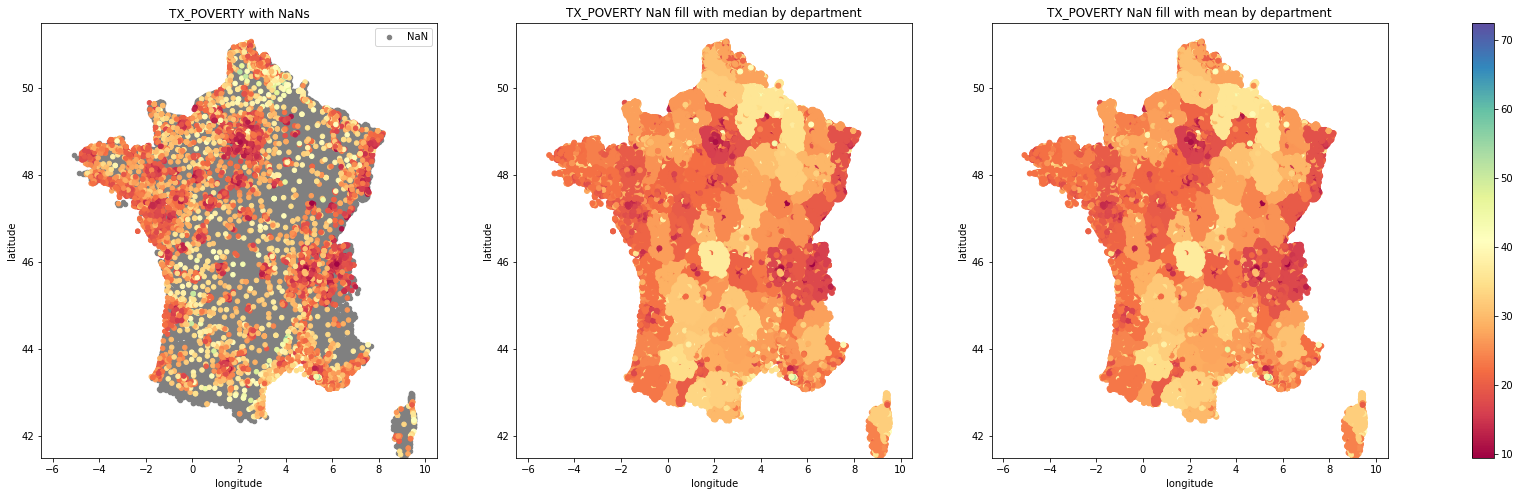

In [403]:
fig, ax = plt.subplots(1,3,figsize = (28,8))
index = data.TX_POVERTY.isna()
ax[0].scatter(data.longitude[index], data.latitude[index], c='gray', s=20,label="NaN")
sc = ax[0].scatter(data.longitude[-index], data.latitude[-index], c=data.TX_POVERTY[-index], s=20,cmap='Spectral')
#fig.colorbar(sc,ax=ax[0])
ax[0].set_title("TX_POVERTY with NaNs")
ax[0].legend()
sc = ax[1].scatter(data_fill_median.longitude,data_fill_median.latitude, c=data_fill_median.TX_POVERTY, s=25,cmap='Spectral')
ax[1].set_title('TX_POVERTY NaN fill with median by department')
#fig.colorbar(sc,ax=ax[1])

sc = ax[2].scatter(data_fill_mean.longitude,data_fill_mean.latitude, c=data_fill_mean.TX_POVERTY, s=25,cmap='Spectral')
ax[2].set_title('TX_POVERTY NaN fill with mean by department')

fig.subplots_adjust(right=0.96)
fig.colorbar(sc, ax=ax.ravel().tolist())

for i in ax:
    i.set_xlim(-6.5, 10.5)
    i.set_ylim(41.5, 51.5)
    i.set_xlabel('longitude')
    i.set_ylabel('latitude')
plt.savefig('tx_poverty.png', bbox_inches='tight')
plt.show()